# Heart Disease Cleveland UCI

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2, f_classif

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

## Содержимое датасета

1. age: age in years  
2. sex: sex (1 = male; 0 = female)  
3. cp: chest pain type  
    -- Value 0: typical angina  
    -- Value 1: atypical angina  
    -- Value 2: non-anginal pain  
    -- Value 3: asymptomatic
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
5. chol: serum cholestoral in mg/dl
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. restecg: resting electrocardiographic results  
    -- Value 0: normal  
    -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)  
    -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
8. thalach: maximum heart rate achieved
9. exang: exercise induced angina (1 = yes; 0 = no)
10. oldpeak = ST depression induced by exercise relative to rest
11. slope: the slope of the peak exercise ST segment -- Value 0: upsloping -- Value 1: flat -- Value 2: downsloping
12. ca: number of major vessels (0-3) colored by flourosopy
13. thal: 0 = normal; 1 = fixed defect; 2 = reversable defect and the label 

Target variable: condition: 0 = no disease, 1 = disease

In [132]:
df = pd.read_csv("data/heart_cleveland_upload.csv")

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [38]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000


## EDA

In [58]:
countNoDisease = len(df[df.condition == 0])
countHaveDisease = len(df[df.condition == 1])
print("Percentage of Patients do not have Heart Disease: {:.2f}%".format((countNoDisease / (len(df.condition)) * 100)))
print("Percentage of Patients have Heart Disease: {:.2f}%".format((countHaveDisease / (len(df.condition)) * 100)))

Percentage of Patients do not have Heart Disease: 53.87%
Percentage of Patients have Heart Disease: 46.13%


Датасет сбалансирован.

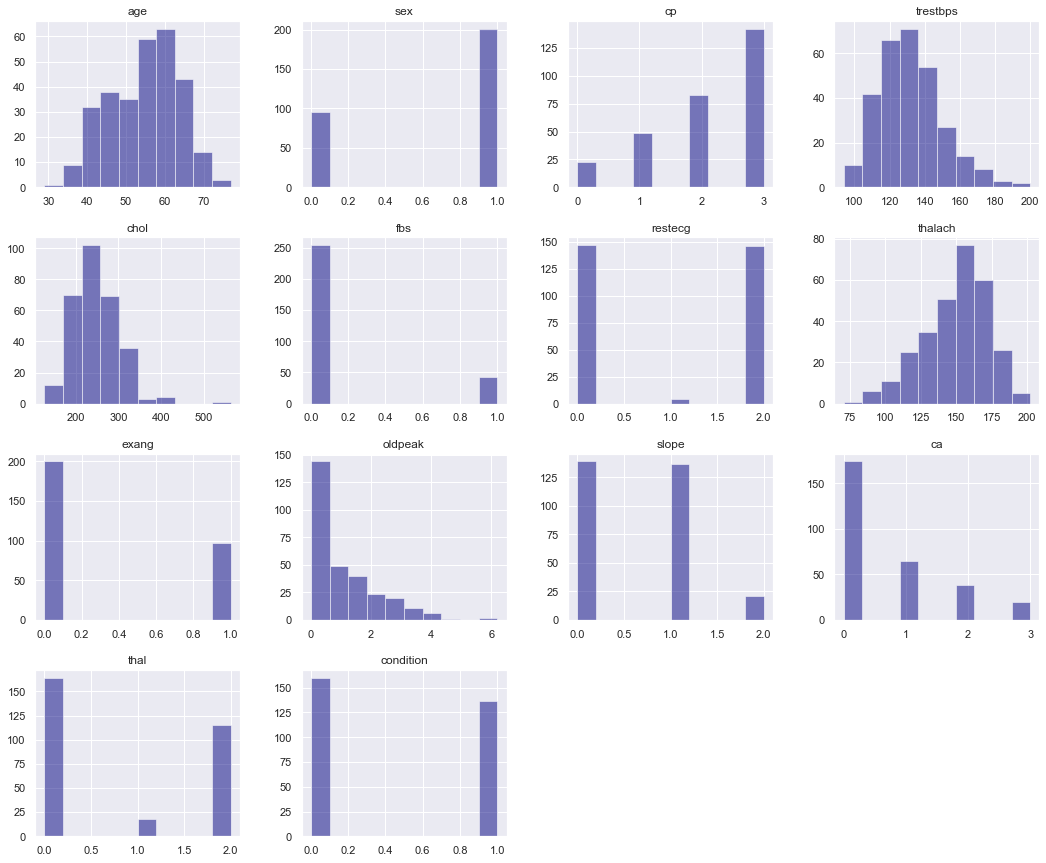

In [60]:
sns.set(style="darkgrid")
df.hist(bins=10,figsize=(18,15) ,color = 'navy', alpha = 0.5)
plt.show()

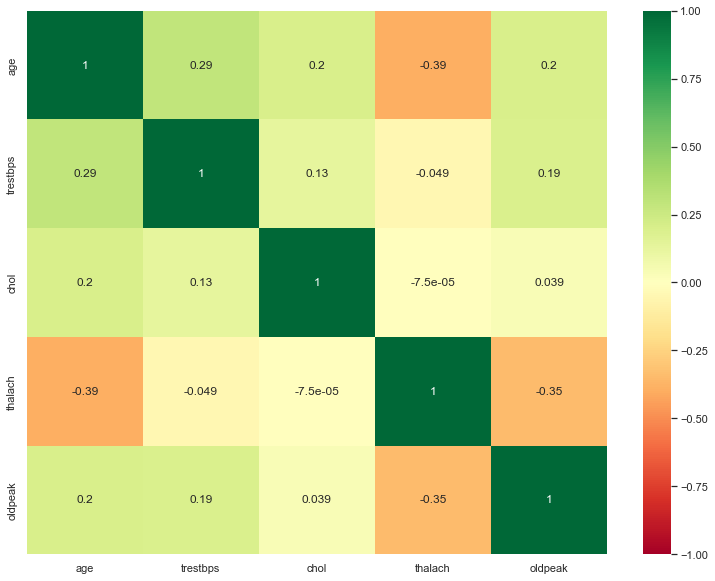

In [52]:
corr = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].corr()
plt.figure(figsize=(13,10))
sns.heatmap(corr, annot=True, vmin=-1.0, cmap="RdYlGn")
plt.show()

## Предобработка данных

In [262]:
from sklearn.compose import ColumnTransformer

In [263]:
numeric_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

categorical_features = ['cp', 'restecg', 'slope', 'ca', 'thal', 'sex']
categorical_transformer = OneHotEncoder(sparse=False)

transformer = ColumnTransformer(
    transformers = [
        ("scale", StandardScaler(), numeric_features),
        ("cat", categorical_transformer, categorical_features)],
    remainder = 'passthrough'
)

In [214]:
scale_list = ['age', 'trestbps', 'chol', 'oldpeak']
ohe_list = ['cp', 'restecg', 'slope', 'ca', 'thal']

transformer = ColumnTransformer([
    ("default", "passthrough", ['sex', 'fbs', 'exang']),
    ("min_max", MinMaxScaler(), scale_list),
    ("ohe", OneHotEncoder(sparse=False), ohe_list)
                                ])

In [295]:
X = df.copy()
y = X['condition']
del X['condition']

In [341]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

#### KNN

In [342]:
from sklearn.pipeline import Pipeline

In [367]:
knn = Pipeline([
    ("transform", transformer),
    ("knn", KNeighborsClassifier(n_neighbors=4))
])

In [368]:
knn.fit(X_train, y_train)
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [369]:
print(classification_report(y_test_pred, y_test))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        35
           1       0.75      0.84      0.79        25

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.81        60
weighted avg       0.82      0.82      0.82        60



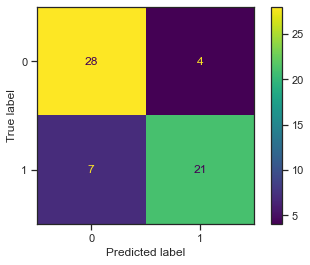

In [370]:
sns.set(style="ticks")
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(knn, X_test, y_test)
plt.show()

#### Logreg

In [400]:
logreg = Pipeline([
    ("transform", transformer),
    ("logreg", LogisticRegression())
])

In [401]:
logreg.fit(X_train, y_train)
y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

In [402]:
print(classification_report(y_test_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83        33
           1       0.79      0.81      0.80        27

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



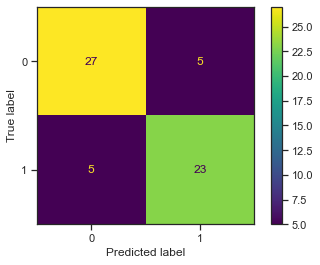

In [399]:
sns.set(style="ticks")
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.show()

#### Naive bayes

In [331]:
from sklearn.naive_bayes import GaussianNB


In [332]:
nb = Pipeline([
    ("transform", transformer),
    ("logreg", GaussianNB())
])

In [333]:
nb.fit(X_train, y_train)
y_train_pred = nb.predict(X_train)
y_test_pred = nb.predict(X_test)

In [334]:
print(classification_report(y_test_pred,y_test))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        29
           1       0.89      0.81      0.85        31

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



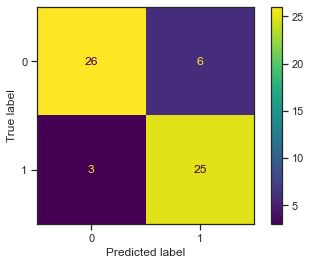

In [335]:
sns.set(style="ticks")
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(nb, X_test, y_test)
plt.show()